In [34]:
import numpy as np
from multitools import gamma_GC
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import islice, combinations
from numpy import random
rng = random.default_rng(seed = 1123)

In [35]:
# parameters # four variables: 3 objectives, 1 constraints
n_obj = 3
n_con = 1  # to simplify my coding i 
r = np.array([      
    [1.0, 0.4, -0.5, 0.3],
    [0.4, 1.0, 0.5, 0.4],
    [-0.5, 0.5, 1.0, 0.2],
    [0.3, 0.4, 0.2, 1.0],
])

shape, scale = [3.0, 4.0, 2.0, 8.0], [2.0, 3, 2,1.0]

In [36]:
n =40
items = gamma_GC(r, n, shape, scale)

In [37]:
def cleanupsamples(samples,nobj,precision=1): 
    samples = np.round(samples,precision)
    c,i = np.unique(samples[:,:nobj], axis=0, return_index=True)
    newsamples = samples[i,:] #note - these have been sorted into increasing magnitude. 
    if precision==0:
        newsamples = np.array(newsamples, dtype='int8')
         
    return newsamples

In [38]:
def non_dominated(objectives):
    n_solutions = objectives.shape[0]
    non_dominated = np.ones(n_solutions, dtype=bool)
    for i in range(n_solutions):
        for j in range(n_solutions):
            if i == j:
                continue

            if np.all(objectives[j, :] >= objectives[i, :]) and \
                np.any(objectives[j, :] > objectives[i, :]):
                non_dominated[i] = False
                break

    return non_dominated

In [39]:
items = cleanupsamples(items,n_obj,precision=0)
print(f"Number of unique items: {items.shape[0]}")

Number of unique items: 39


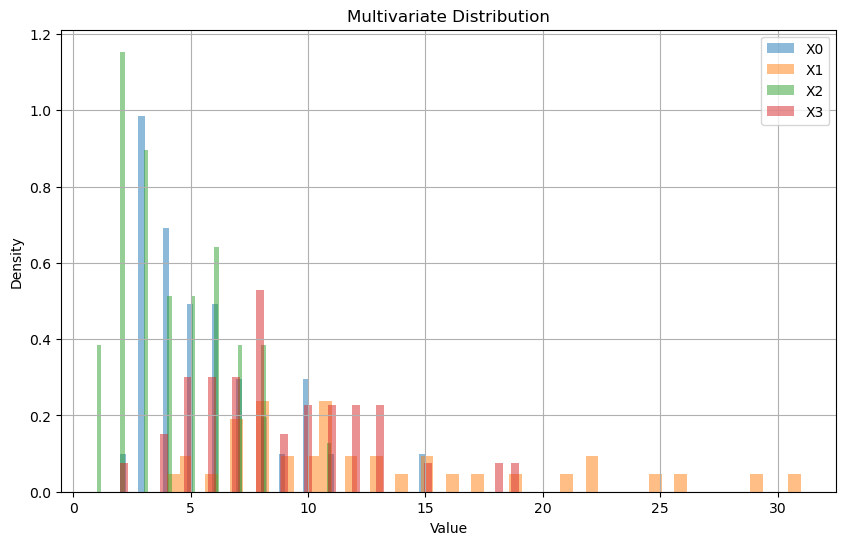

In [40]:
n_dims = items.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_dims):
    plt.hist(items[:, i], bins=50, density=True, alpha=0.5, label=f"X{i}")

plt.title("Multivariate Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.xlim(0, 6)
plt.legend()
plt.grid(True)
plt.show()

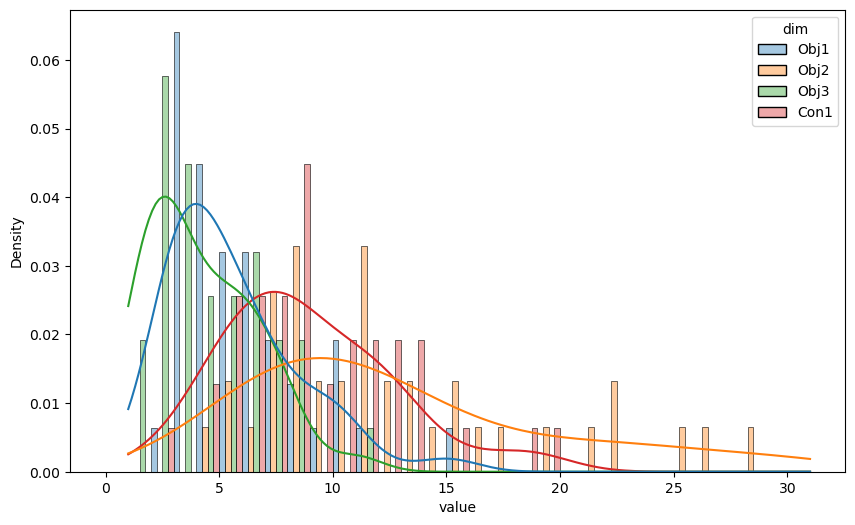

In [41]:
# Convert to DataFrame and melt to long format for seaborn
df = pd.DataFrame(items, columns=['Obj1','Obj2','Obj3','Con1'])
df_long = df.melt(var_name="dim", value_name="value")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_long,
    x="value",
    hue="dim",
    bins=np.arange(0, 30, 1),
    stat="density",
    element="bars",
    fill=True,
    common_bins = True,
    multiple="dodge",
    alpha=0.4,
    kde=True 
)
plt.show()



In [42]:
def get_objectives(samples, indices,nobj):
    objectives = np.zeros((indices.shape[0], nobj),dtype='int16')
    for j in range(indices.shape[0]):
        objectives[j,:] = np.sum(samples[indices[j],:nobj],axis=0,dtype='int16')
    return objectives
def get_constraints(samples, indices,nobj,ncon):
    constraints = np.zeros((indices.shape[0],ncon),dtype='int16')
    for j in range(indices.shape[0]):
        constraints[j,:] = np.sum(samples[indices[j],nobj:],axis=0,dtype='int16')
    constraints = np.squeeze(constraints)
    return constraints

In [43]:
def non_dominated_sort(objectives):
    n_solutions = objectives.shape[0]
    dominated_sets = [[] for _ in range(n_solutions)] # the set of solutions that p dominates
    domination_counts = [0] * n_solutions # the number of solutions that dominate p
    ranks = np.full(n_solutions, -1, dtype=int)           
    fronts = [[]]  

    for p in range(n_solutions):
        for q in range(n_solutions):
            if p == q:
                continue

            if np.all(objectives[p, :] >= objectives[q, :]) and \
                np.any(objectives[p, :] > objectives[q, :]):
                dominated_sets[p].append(q)
            elif np.all(objectives[q, :] >= objectives[p, :]) and \
                np.any(objectives[q, :] > objectives[p, :]):
                domination_counts[p] += 1 
        
        if domination_counts[p] == 0:
            ranks[p] = 0
            fronts[0].append(p)
    
    
    i = 0
    while i < len(fronts) and len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in dominated_sets[p]: 
                domination_counts[q] -= 1
                if domination_counts[q] == 0:
                    ranks[q] = i + 1
                    next_front.append(q)
        
        if next_front:
            fronts.append(next_front)
        i += 1

    dominated_sets = np.array([np.array(s, dtype=int) for s in dominated_sets], dtype=object)
    domination_counts = np.array(domination_counts, dtype=int)
    ranks = np.array(ranks, dtype=int)
    fronts = np.array([np.array(f, dtype=int) for f in fronts if len(f) > 0], dtype=object)

    return  dominated_sets, domination_counts, ranks, fronts


In [44]:
def assign_crowding_distance(objectives):
    distances = np.zeros(objectives.shape[0],  dtype=float)
    for m in range(np.shape(objectives)[1]):
        objective = objectives[:, m]
        sort_indices = np.argsort(objective)[::-1]
        sorted_objective = objective[sort_indices]
        min = sorted_objective[0]
        max = sorted_objective[-1]
        distances[sort_indices[0]] = np.inf
        distances[sort_indices[-1]] = np.inf
        for i in range(1, np.shape(objectives)[0] - 1):
            distances[sort_indices[i]] += (sorted_objective[i + 1] - sorted_objective[i - 1]) \
            / (max - min)
    return distances

In [45]:
def binary_tournament_selection(population, ranks, distances):
    indices = np.arange(len(population))
    i, j = rng.choice(indices, size=2, replace=False)
    if ranks[i] < ranks[j]:
        return i
    if ranks[j] < ranks[i]:
        return j
    else:
        if distances[i] > distances[j]:
            return i
        else:
            return j

In [46]:
def evaluatePopulation(population, n_obj):
    objectives = np.zeros((np.shape(population)[0], n_obj))
    for j in range(np.shape(population)[0]):
        solution = population[j, :]
        objectives[j, :] = np.sum(test_trial.iloc[solution, :3].values, axis=0)
    return np.round(objectives, 1)  # if int, no need to round

def samplePopulation(samples,distribution, pop_size, n_selected, capacity):
    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype='int8')
    n_items = distribution.size
    while pop_count < pop_size:
        knapsack = rng.choice(n_items,n_selected, p=distribution, replace=False)
        constraint = np.sum(samples[knapsack,-1])
        if (constraint <= capacity):
            population[pop_count, :] = knapsack
            pop_count += 1
    return population

In [47]:
#items = np.flipud(np.sort(samples, axis=0))

In [48]:
n_items = items.shape[0]
n_selected  = 5
capacity = int(shape[-1]*scale[-1]*n_selected)
pop_size = 1000
distribution = np.ones(n_items)/n_items
population = samplePopulation(items,distribution, pop_size, n_selected, capacity) 
objectives = get_objectives(items,population,n_obj)
_, _, ranks, fronts = non_dominated_sort(objectives)
distances_all_solutions = np.zeros(population.shape[0], dtype=float)
for f in fronts:
    distances = assign_crowding_distance(objectives[f, :])
    distances_all_solutions[f] = distances

select_indices = np.array([], dtype=int)
while len(select_indices) < pop_size:
    indice = binary_tournament_selection(population, ranks, distances_all_solutions)
    select_indices = np.concatenate([select_indices, np.array([indice])])
selected_population = population[select_indices]
selected_objectives = objectives[select_indices]

distribution = np.ones(n_items)
distribution += np.bincount(selected_population.flatten(), minlength=n_items)
distribution /= np.sum(distribution)
pareto_set = population[fronts[0]]
pareto_front = np.zeros((pareto_set.shape[0],items.shape[1]))
for j in range(pareto_set.shape[0]):
    pareto_front[j,:] = (np.sum(items[pareto_set[j,:],:],axis = 0))

In [49]:
def update_distribution(distribution, items, pop_size,n_selected,n_obj,capacity):
    population = samplePopulation(items,distribution, pop_size, n_selected, capacity) 
    objectives = get_objectives(items,population,n_obj)
    _, _, ranks, fronts = non_dominated_sort(objectives)
    distances_all_solutions = np.zeros(population.shape[0], dtype=float)
    for f in fronts:
        distances = assign_crowding_distance(objectives[f, :])
        distances_all_solutions[f] = distances
    select_indices = np.array([], dtype=int)
    while len(select_indices) < pop_size:
        index = binary_tournament_selection(population, ranks, distances_all_solutions)
        select_indices = np.concatenate([select_indices, np.array([index])])
    selected_population = population[select_indices]
    selected_objectives = objectives[select_indices]
    distribution = np.ones(n_items)
    distribution += np.bincount(selected_population.flatten(), minlength=n_items)
    distribution /= np.sum(distribution)
    pareto_set = population[fronts[0]]
    return distribution, pareto_set 

In [50]:
n_items = items.shape[0]
n_selected  = 5
capacity = int(shape[-1]*scale[-1]*n_items)
pop_size = 1000
distribution = np.ones(n_items)/n_items
distribution,pareto_set= update_distribution(distribution, items, pop_size,n_selected,n_obj,capacity)
pareto_front = np.zeros((pareto_set.shape[0],items.shape[1]))
for j in range(pareto_set.shape[0]):
    pareto_front[j,:] = (np.sum(items[pareto_set[j,:],:],axis = 0))